In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.utils.data as data
import torch.optim as optim

import matplotlib.pyplot as plt

# Tractable experiment

In [3]:
from simulators import Tractable
from datasets import MLTEDataset
from models import MLP, ForkClassifier
from criterions import ForkLoss

In [4]:
simulator = Tractable()
simulator.sample()

(tensor([-2.1252, -1.9024, -2.4287,  0.5343, -2.5342]),
 tensor([ 7.3869, -2.2798,  4.1174, -2.1199, -9.6459, -1.6244, -9.7133, -1.5310]))

In [5]:
subsets = torch.eye(simulator.theta_size[0]).bool()
subsets

tensor([[ True, False, False, False, False],
        [False,  True, False, False, False],
        [False, False,  True, False, False],
        [False, False, False,  True, False],
        [False, False, False, False,  True]])

In [6]:
joint_subsets = []

for i in range(5):
    for j in range(i, 5):
        joint_subsets.append(torch.logical_or(subsets[i], subsets[j]))
    
joint_subsets = torch.stack(joint_subsets)
joint_subsets

tensor([[ True, False, False, False, False],
        [ True,  True, False, False, False],
        [ True, False,  True, False, False],
        [ True, False, False,  True, False],
        [ True, False, False, False,  True],
        [False,  True, False, False, False],
        [False,  True,  True, False, False],
        [False,  True, False,  True, False],
        [False,  True, False, False,  True],
        [False, False,  True, False, False],
        [False, False,  True,  True, False],
        [False, False,  True, False,  True],
        [False, False, False,  True, False],
        [False, False, False,  True,  True],
        [False, False, False, False,  True]])

In [7]:
trainset = MLTEDataset(joint_subsets, simulator).simulate(2 ** 17)

In [8]:
trainloader = data.DataLoader(trainset, batch_size=256, shuffle=True, num_workers=4, pin_memory=True)

In [9]:
encoder = MLP(8, 32, num_layers=3)
model = ForkClassifier(encoder, joint_subsets, num_layers=3).cuda()
criterion = ForkLoss().cuda()
optimizer = optim.Adam(model.parameters(), lr=0.001, amsgrad=True)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=2e-1, patience=2, threshold=1e-2)

In [10]:
model.train()

for epoch in range(50):
    losses = []
    
    for thetas, xs, masks in trainloader:
        logits = model(xs.cuda(), thetas.cuda())
        loss = criterion(logits, masks.cuda(), model.masks)
        
        losses.append(loss.tolist())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    loss = torch.tensor(losses).mean()
    scheduler.step(loss)
    print(loss)

tensor(1.1822)
tensor(1.0179)
tensor(0.9050)
tensor(0.8501)
tensor(0.8225)
tensor(0.8003)
tensor(0.7913)
tensor(0.7818)
tensor(0.7709)
tensor(0.7691)
tensor(0.7641)
tensor(0.7570)
tensor(0.7554)
tensor(0.7512)
tensor(0.7519)
tensor(0.7197)
tensor(0.7080)
tensor(0.7090)
tensor(0.7062)
tensor(0.7080)
tensor(0.6977)
tensor(0.6958)
tensor(0.6961)
tensor(0.6975)
tensor(0.6947)
tensor(0.6942)
tensor(0.6945)
tensor(0.6929)
tensor(0.6961)
tensor(0.6925)
tensor(0.6934)
tensor(0.6933)
tensor(0.6928)
tensor(0.6947)
tensor(0.6962)
tensor(0.6939)
tensor(0.6920)
tensor(0.6948)
tensor(0.6926)
tensor(0.6927)
tensor(0.6964)
tensor(0.6919)
tensor(0.6913)
tensor(0.6916)
tensor(0.6911)
tensor(0.6937)
tensor(0.6967)
tensor(0.6921)
tensor(0.6940)
tensor(0.6907)


In [11]:
simulator.theta_star

tensor([ 0.7000, -2.9000, -1.0000, -0.9000,  0.6000])

In [12]:
x_star = simulator(simulator.theta_star.cuda())
x_star

tensor([ 0.0696, -3.5250,  0.8090, -2.5929,  0.7216, -2.6038,  2.2792, -2.4092],
       device='cuda:0')

In [13]:
model.eval()

steps = 120

domain = torch.linspace(-3., 3., steps)
grids = torch.meshgrid(domain, domain, torch.zeros(1), torch.zeros(1), torch.zeros(1))
thetas = torch.stack(grids, dim=-1).view(-1, 5)
select = [1]

p = []

with torch.no_grad():
    for val in torch.split(thetas, 256):
        logits = model(x_star.repeat(val.size(0), 1), val.cuda(), select)
        p.append((logits + 2 * torch.tensor(1. / 6).log()).exp().cpu())
        
p = torch.cat(p)

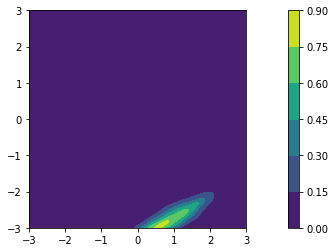

In [14]:
plt.contourf(
    thetas[:, 0].view(steps, steps).numpy(),
    thetas[:, 1].view(steps, steps).numpy(),
    p.view(steps, steps).numpy()
)
plt.colorbar()
plt.axis('square')
plt.show()